# Clustering and Viz Experimentation

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
import os
import sys

module_path = os.path.abspath(os.path.join('rcnn/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels

In [120]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

### importing datasets

In [38]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

class_dict = util.indexed_dictionary

tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']
#tiles['028012'] = ['20110831']
#tiles['029011'] = ['20110831']
#tiles['028011'] = ['20110831']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets
    
tile_size = 5
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
clean_pixels_count = 500
max_count_per_class = 200

checking general values for pixels

In [72]:
tile_list = ['028011']
px = rnn_pixels.make_pixels(1, tile_list)

In [102]:
n = 200000
random_px_subset = random.sample(px, n)
random_px_subset

[((3073, 3887), '028011'),
 ((1108, 4866), '028011'),
 ((2811, 1584), '028011'),
 ((292, 4811), '028011'),
 ((1031, 488), '028011'),
 ((3535, 4315), '028011'),
 ((2492, 2495), '028011'),
 ((1367, 2289), '028011'),
 ((4125, 2426), '028011'),
 ((211, 838), '028011'),
 ((1573, 1244), '028011'),
 ((1083, 662), '028011'),
 ((388, 1544), '028011'),
 ((355, 3747), '028011'),
 ((143, 1955), '028011'),
 ((771, 1326), '028011'),
 ((1967, 166), '028011'),
 ((3917, 2100), '028011'),
 ((379, 2809), '028011'),
 ((924, 4824), '028011'),
 ((3638, 4151), '028011'),
 ((2190, 4260), '028011'),
 ((4909, 4507), '028011'),
 ((3989, 1331), '028011'),
 ((3659, 644), '028011'),
 ((890, 491), '028011'),
 ((799, 4152), '028011'),
 ((2856, 2431), '028011'),
 ((1947, 3336), '028011'),
 ((1364, 3737), '028011'),
 ((3469, 3760), '028011'),
 ((3491, 4820), '028011'),
 ((2366, 1884), '028011'),
 ((2641, 2142), '028011'),
 ((1927, 665), '028011'),
 ((1198, 4432), '028011'),
 ((4478, 546), '028011'),
 ((4106, 79), '0280

In [103]:
tile_size = 1
px_to_use = random_px_subset
clean_pixels = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, px_to_use, tile_size, buffer_pix=1)
print(len(clean_pixels))

16428


In [121]:
tile_size=1
batch_size=1
class_count = 6
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
w_generator = tile_gen.tile_generator(clean_pixels, batch_size=1, flatten=True, normalize=False)

In [105]:
all_imgs = []
count = 0
while count < len(clean_pixels):
    image_b, label_b = next(w_generator)
    #label_b = np.argmax(label_b)#['landcover'])
    for i in range(0,5):
        all_imgs.append(image_b[0,i,0,0,:])
    count +=1

In [106]:
random_data = np.array(all_imgs)
random_data.shape

(82140, 7)

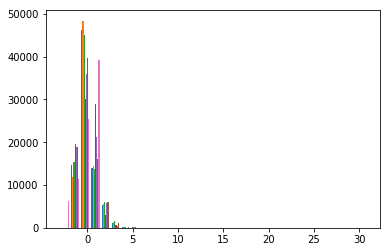

In [107]:
plt.hist(random_data, bins=30)
plt.show()

array([ 0.00013877,  0.00281835,  0.00154412, -0.00385169, -0.0025389 ,
       -0.00220002, -0.00893965])

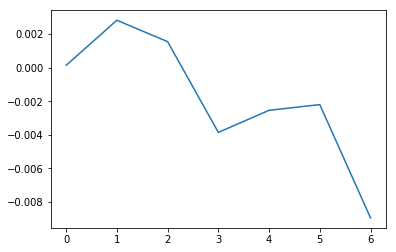

In [108]:
fig, ax = plt.subplots()
ax.plot(np.mean(random_data,axis=0))
#ax.set_ylim(-.01,.01)
np.mean(random_data,axis=0)

array([ 380.58769968,  479.86798266,  489.28261068, 1713.32453218,
       1309.45538567,  715.15162026, 3956.36700137])

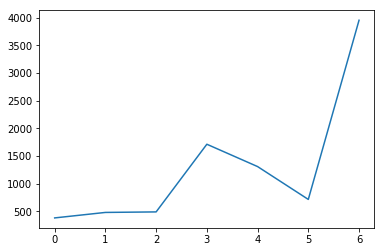

In [34]:
plt.plot(np.mean(random_data,axis=0))
np.mean(random_data,axis=0)

array([-0.28909785, -0.28407664, -0.33159978,  0.20044643, -0.02453593,
       -0.21584265,  0.29805852])

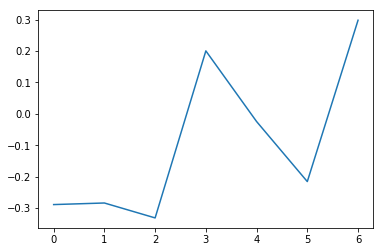

In [109]:
plt.plot(np.median(random_data,axis=0))
np.median(random_data,axis=0)

array([ 331.,  418.,  384., 1940., 1292.,  571., 5257.])

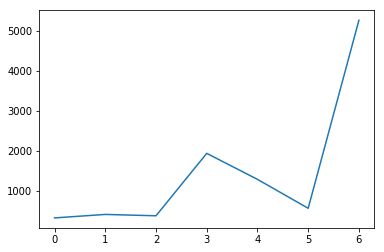

In [35]:
plt.plot(np.median(random_data,axis=0))
np.median(random_data,axis=0)

array([0.97451754, 0.98998343, 0.99476255, 1.00433437, 1.00116176,
       1.00303905, 1.00738935])

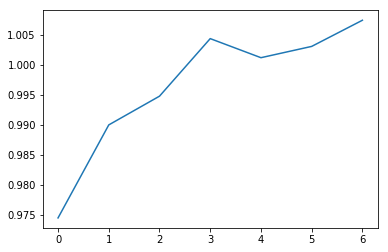

In [110]:
fig,ax = plt.subplots()
ax.plot(np.std(random_data,axis=0))
#ax.set_ylim(-.01,.01)
np.std(random_data,axis=0)

array([ 175.25217965,  225.9591124 ,  305.45667311, 1034.26438641,
        923.85904657,  621.31612253, 3940.24286162])

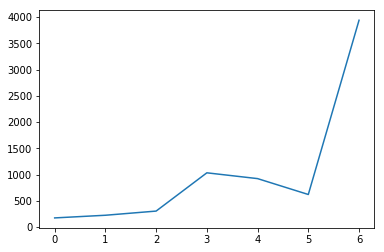

In [36]:
plt.plot(np.std(random_data,axis=0))
np.std(random_data,axis=0)

In [111]:
import geopandas as gpd
# load in pix from shapefile
train_gdf = gpd.read_file('train_buffered_points.shp')
train_px = []
for index, row in train_gdf.iterrows():
    train_px.append(((row['row'], row['col']), row['tile_name']))

random.shuffle(train_px)

len(train_px), train_px[0]

(9000, ((674, 3576), '028012'))

In [122]:
tile_size=1
batch_size=1
class_count = 6
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
w_generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, normalize=False)

lc_lab = np.empty(len(train_px))
all_imgs = []
count = 0
while count < len(train_px):
    image_b, label_b = next(w_generator)
    label_lc = np.argmax(label_b, axis=-1)
    lc_lab[count] = label_lc
    all_imgs.append(image_b[0,:,0,0,:])
    count +=1

In [123]:
#label_index = lc_lab.reshape(len(val_px)*1*1)
all_imgs = np.array(all_imgs)
all_imgs.shape, lc_lab.shape

((9000, 5, 7), (9000,))

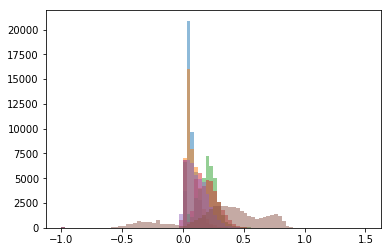

In [125]:
for i in range(1,7):
    plt.hist(all_imgs[:,:,i].flatten(), bins=80, range=(-1,1.5), alpha=0.5)
plt.show()

## Spectral Signatures

Landsat 5 specs from USGS https://www.usgs.gov/land-resources/nli/landsat/landsat-5

In [131]:
np.mean(all_imgs[lc_lab==0, :,:], axis=0).shape

(5, 7)

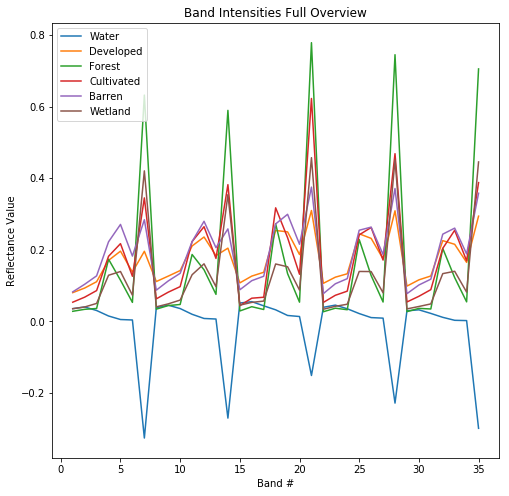

In [132]:
fig, ax = plt.subplots(1,1, figsize=[8,8])

# numbers 1-8
band_count = np.arange(1,36)

for class_index in class_dict:
    band_intensity = np.mean(all_imgs[lc_lab==class_index, :,:], axis=0).flatten()
    ax.plot(band_count, band_intensity, label=class_dict[class_index])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


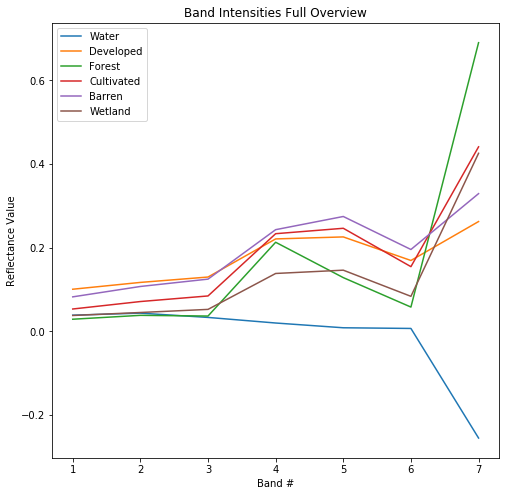

In [136]:
fig, ax = plt.subplots(1,1, figsize=[8,8])

# numbers 1-8
band_count = np.arange(1,8)

for class_index in class_dict:
    # reshape into 5 time steps of 
    time_steps = len(tiles['028012'])
    band_intensity = np.mean(all_imgs[lc_lab==class_index,:,:].reshape(-1,time_steps,7), axis=(0,1))
    ax.plot(band_count, band_intensity, label=class_dict[class_index])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


### Dendrogram

In [144]:
np.mean(all_imgs,axis=1).shape

(9000, 7)

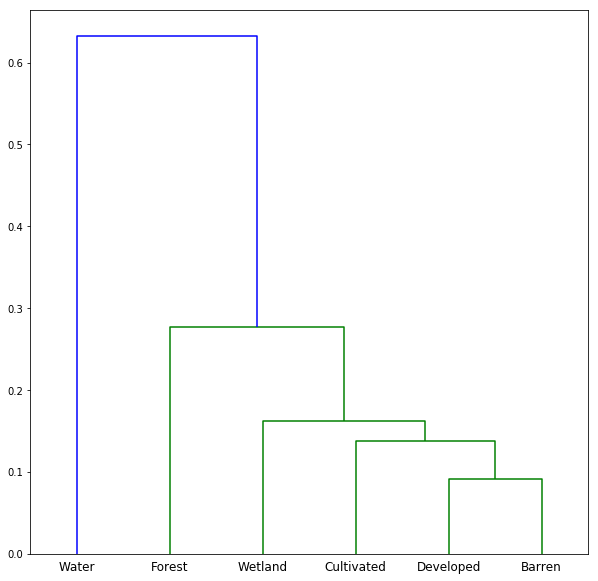

In [145]:
from scipy.cluster import hierarchy

image_avgs = []    
all_imgs_yearly_mean = np.mean(all_imgs,axis=1)
for class_index in class_dict:
    image_avgs.append(np.mean(all_imgs_yearly_mean[lc_lab==class_index, :], axis=0))

ytdist = np.array(image_avgs)

Z = hierarchy.linkage(ytdist, 'single')
plt.figure(figsize=(10,10))
dn = hierarchy.dendrogram(Z, labels=list(class_dict.values()))

### PCA and Clustering

In [147]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_imgs_yearly_mean)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

df = pd.DataFrame({'pca-one':pca_result[:,0],'pca-two':pca_result[:,1],'pca-three':pca_result[:,2], 'y' : lc_lab})

Explained variation per principal component: [0.79776647 0.18354755 0.01238724]


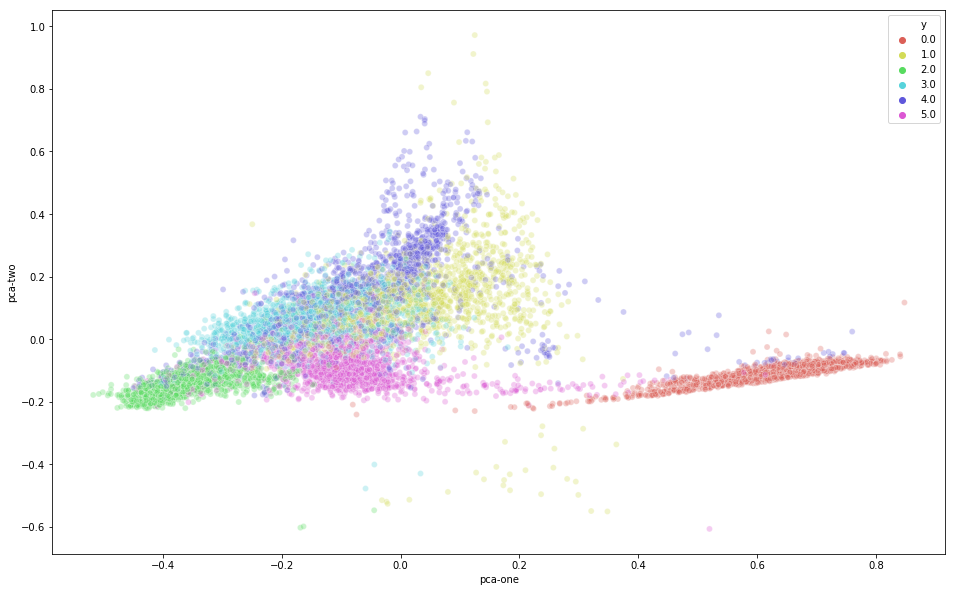

In [148]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(lc_lab))),
    data=df,
    legend="full",
    alpha=0.3
)

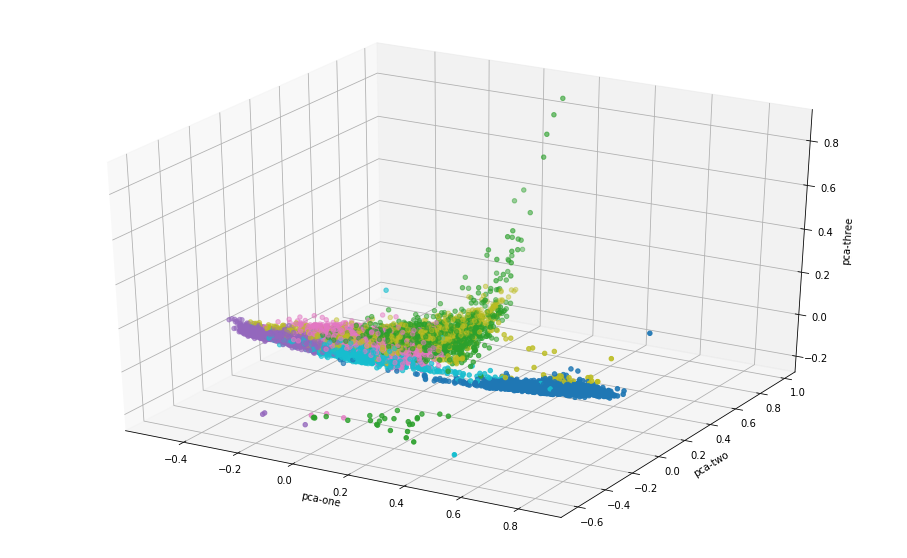

In [149]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [13]:
from time import time
from sklearn.manifold import TSNE

N = 10000
data_subset = sk_data[:N, :]

time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 901 samples in 0.001s...
[t-SNE] Computed neighbors for 901 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 901 / 901
[t-SNE] Mean sigma: 1.001957
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.736160
[t-SNE] KL divergence after 1000 iterations: 0.467313
t-SNE done! Time elapsed: 5.8433518409729 seconds


In [14]:
df_subset = df.loc[:N-1,:].copy()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

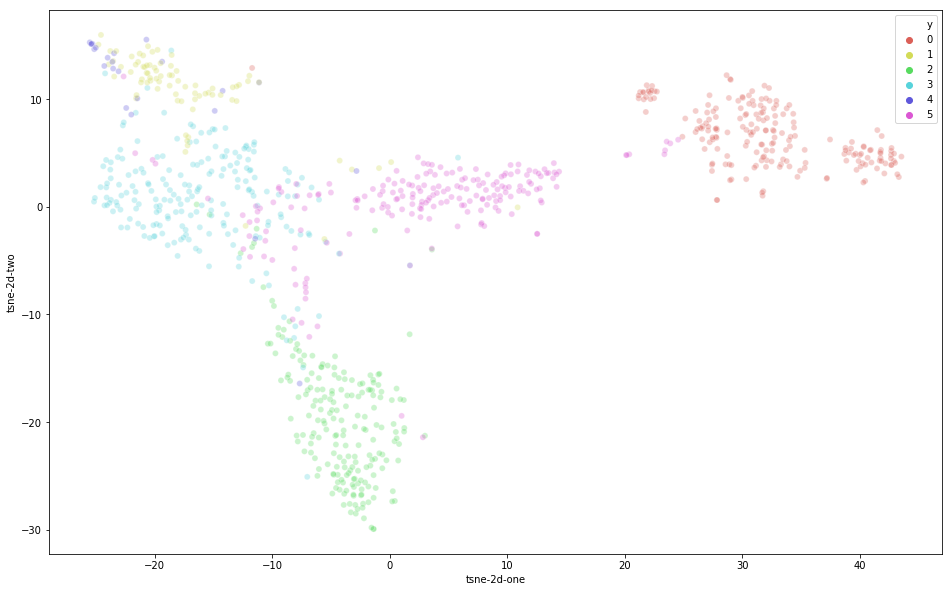

In [15]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(sk_labels))),
    data=df_subset,
    legend="full",
    alpha=0.3
)